# Method 3 - Best Fresh Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
# Backtest the Portfolio

w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

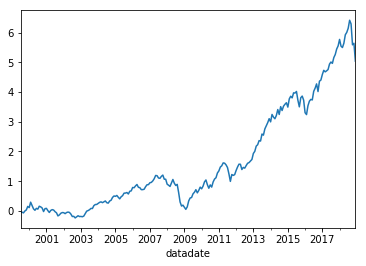

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.151565
2000-12-31   -0.065058
2001-12-31   -0.122810
2002-12-31   -0.142388
2003-12-31    0.503398
2004-12-31    0.233995
2005-12-31    0.113852
2006-12-31    0.125928
2007-12-31    0.096293
2008-12-31   -0.422283
2009-12-31    0.508542
2010-12-31    0.264184
2011-12-31   -0.024253
2012-12-31    0.229825
2013-12-31    0.502411
2014-12-31    0.131016
2015-12-31    0.018502
2016-12-31    0.143136
2017-12-31    0.213004
2018-12-31   -0.078613
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     585.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.91e-119
Time:                        13:29:52   Log-Likelihood:                 645.99
No. Observations:                 234   AIC:                            -1282.
Df Residuals:                     229   BIC:                            -1265.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.252      0.001       0.001       0.006
mktrf          0.9623      0.029     33.348      0.000       0.905       1.019
me             0.4781      0.034     14.243      0.000       0.412       0.544
ia            -0.0427      0.051     -0.836      0.404      -0.143       0.058
roe           -0.0041      0.044     -0.094      0.926      -0.090       0.082
==============================================================================
Omnibus:                       34.079   Durbin-Watson:                   2.204
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.448
Skew:                          -0.525   Prob(JB):                     1.15e-26
Kurtosis:                       6.339   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     671.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.56e-125
Time:                        13:29:52   Log-Likelihood:                 645.99
No. Observations:                 234   AIC:                            -1282.
Df Residuals:                     229   BIC:                            -1265.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.475      0.001       0.001       0.005
mktrf          0.9623      0.042     23.101      0.000       0.881       1.044
me             0.4781      0.049      9.666      0.000       0.381       0.575
ia            -0.0427      0.094     -0.452      0.651      -0.227       0.142
roe           -0.0041      0.066     -0.062      0.951      -0.134       0.125
==============================================================================
Omnibus:                       34.079   Durbin-Watson:                   2.204
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.448
Skew:                          -0.525   Prob(JB):                     1.15e-26
Kurtosis:                       6.339   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     812.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.48e-134
Time:                        13:29:52   Log-Likelihood:                 645.99
No. Observations:                 234   AIC:                            -1282.
Df Residuals:                     229   BIC:                            -1265.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.656      0.000       0.002       0.005
mktrf          0.9623      0.029     32.829      0.000       0.905       1.020
me             0.4781      0.049      9.779      0.000       0.382       0.574
ia            -0.0427      0.093     -0.457      0.647      -0.225       0.140
roe           -0.0041      0.058     -0.070      0.944      -0.118       0.110
==============================================================================
Omnibus:                       34.079   Durbin-Watson:                   2.204
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.448
Skew:                          -0.525   Prob(JB):                     1.15e-26
Kurtosis:                       6.339   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     406.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.04e-111
Time:                        13:29:52   Log-Likelihood:                 631.49
No. Observations:                 234   AIC:                            -1251.
Df Residuals:                     228   BIC:                            -1230.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.229      0.001       0.001       0.006
mktrf          0.9584      0.031     31.090      0.000       0.898       1.019
smb            0.4731      0.041     11.630      0.000       0.393       0.553
hml           -0.0478      0.048     -0.996      0.320      -0.142       0.047
rmw           -0.0643      0.054     -1.186      0.237      -0.171       0.043
cma            0.0712      0.069      1.032      0.303      -0.065       0.207
==============================================================================
Omnibus:                       20.411   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.352
Skew:                          -0.189   Prob(JB):                     1.44e-15
Kurtosis:                       5.621   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     432.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.59e-114
Time:                        13:29:52   Log-Likelihood:                 631.49
No. Observations:                 234   AIC:                            -1251.
Df Residuals:                     228   BIC:                            -1230.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.580      0.000       0.002       0.006
mktrf          0.9584      0.049     19.676      0.000       0.863       1.054
smb            0.4731      0.049      9.738      0.000       0.378       0.568
hml           -0.0478      0.077     -0.620      0.535      -0.199       0.103
rmw           -0.0643      0.087     -0.737      0.461      -0.235       0.107
cma            0.0712      0.145      0.491      0.623      -0.213       0.355
==============================================================================
Omnibus:                       20.411   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.352
Skew:                          -0.189   Prob(JB):                     1.44e-15
Kurtosis:                       5.621   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     558.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.48e-126
Time:                        13:29:52   Log-Likelihood:                 631.49
No. Observations:                 234   AIC:                            -1251.
Df Residuals:                     228   BIC:                            -1230.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      4.106      0.000       0.002       0.005
mktrf          0.9584      0.048     19.887      0.000       0.864       1.053
smb            0.4731      0.043     11.084      0.000       0.389       0.557
hml           -0.0478      0.077     -0.617      0.537      -0.199       0.104
rmw           -0.0643      0.094     -0.686      0.493      -0.248       0.119
cma            0.0712      0.160      0.445      0.656      -0.242       0.384
==============================================================================
Omnibus:                       20.411   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.352
Skew:                          -0.189   Prob(JB):                     1.44e-15
Kurtosis:                       5.621   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     519.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.35e-113
Time:                        13:29:52   Log-Likelihood:                 633.37
No. Observations:                 234   AIC:                            -1257.
Df Residuals:                     229   BIC:                            -1239.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.776      0.006       0.001       0.005
mktrf          1.0152      0.028     36.208      0.000       0.960       1.070
smb            0.4389      0.035     12.539      0.000       0.370       0.508
hml            0.0753      0.035      2.164      0.031       0.007       0.144
umd            0.0890      0.023      3.902      0.000       0.044       0.134
==============================================================================
Omnibus:                       27.904   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.914
Skew:                          -0.004   Prob(JB):                     2.29e-34
Kurtosis:                       6.986   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     509.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.15e-112
Time:                        13:29:52   Log-Likelihood:                 633.37
No. Observations:                 234   AIC:                            -1257.
Df Residuals:                     229   BIC:                            -1239.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.637      0.008       0.001       0.005
mktrf          1.0152      0.040     25.680      0.000       0.938       1.093
smb            0.4389      0.051      8.620      0.000       0.339       0.539
hml            0.0753      0.063      1.198      0.231      -0.048       0.198
umd            0.0890      0.052      1.709      0.088      -0.013       0.191
==============================================================================
Omnibus:                       27.904   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.914
Skew:                          -0.004   Prob(JB):                     2.29e-34
Kurtosis:                       6.986   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     773.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.07e-131
Time:                        13:29:52   Log-Likelihood:                 633.37
No. Observations:                 234   AIC:                            -1257.
Df Residuals:                     229   BIC:                            -1239.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.099      0.002       0.001       0.005
mktrf          1.0152      0.030     33.725      0.000       0.956       1.074
smb            0.4389      0.036     12.151      0.000       0.368       0.510
hml            0.0753      0.063      1.198      0.231      -0.048       0.198
umd            0.0890      0.047      1.884      0.060      -0.004       0.182
==============================================================================
Omnibus:                       27.904   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.914
Skew:                          -0.004   Prob(JB):                     2.29e-34
Kurtosis:                       6.986   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     240.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.63e-55
Time:                        13:29:52   Log-Likelihood:                 306.95
No. Observations:                 120   AIC:                            -603.9
Df Residuals:                     115   BIC:                            -590.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.566      0.120      -0.001       0.006
mktrf          0.9759      0.049     19.774      0.000       0.878       1.074
me             0.5082      0.049     10.426      0.000       0.412       0.605
ia            -0.0510      0.076     -0.668      0.506      -0.202       0.100
roe            0.0589      0.068      0.872      0.385      -0.075       0.193
==============================================================================
Omnibus:                       15.133   Durbin-Watson:                   2.283
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               27.771
Skew:                          -0.530   Prob(JB):                     9.32e-07
Kurtosis:                       5.105   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     382.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.02e-65
Time:                        13:29:52   Log-Likelihood:                 306.95
No. Observations:                 120   AIC:                            -603.9
Df Residuals:                     115   BIC:                            -590.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.645      0.100      -0.001       0.006
mktrf          0.9759      0.072     13.629      0.000       0.836       1.116
me             0.5082      0.061      8.341      0.000       0.389       0.628
ia            -0.0510      0.117     -0.436      0.663      -0.280       0.178
roe            0.0589      0.090      0.654      0.513      -0.118       0.236
==============================================================================
Omnibus:                       15.133   Durbin-Watson:                   2.283
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               27.771
Skew:                          -0.530   Prob(JB):                     9.32e-07
Kurtosis:                       5.105   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     418.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.71e-67
Time:                        13:29:52   Log-Likelihood:                 306.95
No. Observations:                 120   AIC:                            -603.9
Df Residuals:                     115   BIC:                            -590.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.694      0.090      -0.000       0.006
mktrf          0.9759      0.049     19.979      0.000       0.880       1.072
me             0.5082      0.062      8.206      0.000       0.387       0.630
ia            -0.0510      0.115     -0.441      0.659      -0.277       0.175
roe            0.0589      0.066      0.897      0.370      -0.070       0.188
==============================================================================
Omnibus:                       15.133   Durbin-Watson:                   2.283
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               27.771
Skew:                          -0.530   Prob(JB):                     9.32e-07
Kurtosis:                       5.105   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     158.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.27e-49
Time:                        13:29:52   Log-Likelihood:                 297.22
No. Observations:                 120   AIC:                            -582.4
Df Residuals:                     114   BIC:                            -565.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      1.889      0.061      -0.000       0.008
mktrf          0.9785      0.057     17.263      0.000       0.866       1.091
smb            0.5151      0.064      8.023      0.000       0.388       0.642
hml           -0.0926      0.079     -1.177      0.242      -0.248       0.063
rmw            0.0158      0.093      0.171      0.865      -0.168       0.200
cma            0.1066      0.102      1.049      0.296      -0.095       0.308
==============================================================================
Omnibus:                        6.321   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                8.394
Skew:                          -0.244   Prob(JB):                       0.0150
Kurtosis:                       4.201   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     229.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.79e-58
Time:                        13:29:52   Log-Likelihood:                 297.22
No. Observations:                 120   AIC:                            -582.4
Df Residuals:                     114   BIC:                            -565.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      2.271      0.023       0.001       0.007
mktrf          0.9785      0.097     10.094      0.000       0.789       1.169
smb            0.5151      0.070      7.344      0.000       0.378       0.653
hml           -0.0926      0.124     -0.748      0.455      -0.335       0.150
rmw            0.0158      0.161      0.098      0.922      -0.300       0.332
cma            0.1066      0.180      0.592      0.554      -0.246       0.459
==============================================================================
Omnibus:                        6.321   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                8.394
Skew:                          -0.244   Prob(JB):                       0.0150
Kurtosis:                       4.201   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     255.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.78e-60
Time:                        13:29:52   Log-Likelihood:                 297.22
No. Observations:                 120   AIC:                            -582.4
Df Residuals:                     114   BIC:                            -565.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      2.707      0.007       0.001       0.007
mktrf          0.9785      0.102      9.641      0.000       0.780       1.177
smb            0.5151      0.068      7.619      0.000       0.383       0.648
hml           -0.0926      0.133     -0.698      0.485      -0.353       0.167
rmw            0.0158      0.185      0.086      0.932      -0.346       0.377
cma            0.1066      0.193      0.552      0.581      -0.272       0.485
==============================================================================
Omnibus:                        6.321   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                8.394
Skew:                          -0.244   Prob(JB):                       0.0150
Kurtosis:                       4.201   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     204.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.57e-51
Time:                        13:29:52   Log-Likelihood:                 298.46
No. Observations:                 120   AIC:                            -586.9
Df Residuals:                     115   BIC:                            -573.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.093      0.039       0.000       0.008
mktrf          1.0273      0.047     22.012      0.000       0.935       1.120
smb            0.4365      0.053      8.216      0.000       0.331       0.542
hml            0.0813      0.053      1.528      0.129      -0.024       0.187
umd            0.0983      0.033      2.997      0.003       0.033       0.163
==============================================================================
Omnibus:                       12.057   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               33.690
Skew:                          -0.124   Prob(JB):                     4.83e-08
Kurtosis:                       5.584   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     288.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.71e-59
Time:                        13:29:52   Log-Likelihood:                 298.46
No. Observations:                 120   AIC:                            -586.9
Df Residuals:                     115   BIC:                            -573.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.087      0.037       0.000       0.008
mktrf          1.0273      0.063     16.267      0.000       0.903       1.151
smb            0.4365      0.070      6.209      0.000       0.299       0.574
hml            0.0813      0.078      1.036      0.300      -0.073       0.235
umd            0.0983      0.065      1.522      0.128      -0.028       0.225
==============================================================================
Omnibus:                       12.057   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               33.690
Skew:                          -0.124   Prob(JB):                     4.83e-08
Kurtosis:                       5.584   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     415.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.39e-67
Time:                        13:29:52   Log-Likelihood:                 298.46
No. Observations:                 120   AIC:                            -586.9
Df Residuals:                     115   BIC:                            -573.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.386      0.017       0.001       0.007
mktrf          1.0273      0.045     22.584      0.000       0.938       1.116
smb            0.4365      0.049      8.832      0.000       0.340       0.533
hml            0.0813      0.079      1.026      0.305      -0.074       0.237
umd            0.0983      0.054      1.828      0.068      -0.007       0.204
==============================================================================
Omnibus:                       12.057   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               33.690
Skew:                          -0.124   Prob(JB):                     4.83e-08
Kurtosis:                       5.584   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     527.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.59e-70
Time:                        13:29:52   Log-Likelihood:                 367.18
No. Observations:                 114   AIC:                            -724.4
Df Residuals:                     109   BIC:                            -710.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.916      0.000       0.002       0.006
mktrf          0.9769      0.029     33.638      0.000       0.919       1.034
me             0.3795      0.045      8.463      0.000       0.291       0.468
ia            -0.0959      0.062     -1.542      0.126      -0.219       0.027
roe           -0.2040      0.055     -3.732      0.000      -0.312      -0.096
==============================================================================
Omnibus:                        5.211   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                2.603
Skew:                          -0.026   Prob(JB):                        0.272
Kurtosis:                       2.262   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     763.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-78
Time:                        13:29:52   Log-Likelihood:                 367.18
No. Observations:                 114   AIC:                            -724.4
Df Residuals:                     109   BIC:                            -710.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      4.200      0.000       0.002       0.006
mktrf          0.9769      0.022     44.327      0.000       0.934       1.020
me             0.3795      0.038      9.952      0.000       0.305       0.454
ia            -0.0959      0.073     -1.316      0.188      -0.239       0.047
roe           -0.2040      0.075     -2.729      0.006      -0.350      -0.057
==============================================================================
Omnibus:                        5.211   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                2.603
Skew:                          -0.026   Prob(JB):                        0.272
Kurtosis:                       2.262   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     1784.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.52e-98
Time:                        13:29:52   Log-Likelihood:                 367.18
No. Observations:                 114   AIC:                            -724.4
Df Residuals:                     109   BIC:                            -710.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      4.487      0.000       0.002       0.006
mktrf          0.9769      0.020     49.923      0.000       0.939       1.015
me             0.3795      0.029     13.156      0.000       0.323       0.436
ia            -0.0959      0.081     -1.180      0.238      -0.255       0.063
roe           -0.2040      0.071     -2.870      0.004      -0.343      -0.065
==============================================================================
Omnibus:                        5.211   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                2.603
Skew:                          -0.026   Prob(JB):                        0.272
Kurtosis:                       2.262   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     454.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.15e-71
Time:                        13:29:52   Log-Likelihood:                 371.78
No. Observations:                 114   AIC:                            -731.6
Df Residuals:                     108   BIC:                            -715.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.067      0.003       0.001       0.005
mktrf          0.9833      0.027     36.793      0.000       0.930       1.036
smb            0.3595      0.043      8.287      0.000       0.274       0.446
hml           -0.0548      0.055     -0.990      0.324      -0.164       0.055
rmw           -0.3300      0.068     -4.871      0.000      -0.464      -0.196
cma           -0.0207      0.086     -0.241      0.810      -0.191       0.150
==============================================================================
Omnibus:                        2.379   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.304   Jarque-Bera (JB):                1.652
Skew:                          -0.048   Prob(JB):                        0.438
Kurtosis:                       2.418   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     519.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.17e-74
Time:                        13:29:52   Log-Likelihood:                 371.78
No. Observations:                 114   AIC:                            -731.6
Df Residuals:                     108   BIC:                            -715.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.543      0.000       0.001       0.005
mktrf          0.9833      0.024     40.888      0.000       0.936       1.030
smb            0.3595      0.035     10.134      0.000       0.290       0.429
hml           -0.0548      0.048     -1.134      0.257      -0.149       0.040
rmw           -0.3300      0.052     -6.385      0.000      -0.431      -0.229
cma           -0.0207      0.073     -0.284      0.776      -0.163       0.122
==============================================================================
Omnibus:                        2.379   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.304   Jarque-Bera (JB):                1.652
Skew:                          -0.048   Prob(JB):                        0.438
Kurtosis:                       2.418   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     1114.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.52e-91
Time:                        13:29:52   Log-Likelihood:                 371.78
No. Observations:                 114   AIC:                            -731.6
Df Residuals:                     108   BIC:                            -715.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.998      0.000       0.001       0.004
mktrf          0.9833      0.019     50.622      0.000       0.945       1.021
smb            0.3595      0.026     13.760      0.000       0.308       0.411
hml           -0.0548      0.046     -1.201      0.230      -0.144       0.035
rmw           -0.3300      0.048     -6.897      0.000      -0.424      -0.236
cma           -0.0207      0.073     -0.283      0.777      -0.164       0.123
==============================================================================
Omnibus:                        2.379   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.304   Jarque-Bera (JB):                1.652
Skew:                          -0.048   Prob(JB):                        0.438
Kurtosis:                       2.418   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     465.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.63e-67
Time:                        13:29:52   Log-Likelihood:                 360.43
No. Observations:                 114   AIC:                            -710.9
Df Residuals:                     109   BIC:                            -697.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.908      0.059   -7.74e-05       0.004
mktrf          1.0172      0.029     34.837      0.000       0.959       1.075
smb            0.4248      0.046      9.329      0.000       0.335       0.515
hml            0.0361      0.047      0.770      0.443      -0.057       0.129
umd            0.0473      0.035      1.336      0.184      -0.023       0.117
==============================================================================
Omnibus:                        1.454   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.483   Jarque-Bera (JB):                1.213
Skew:                           0.033   Prob(JB):                        0.545
Kurtosis:                       2.499   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     317.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.68e-59
Time:                        13:29:52   Log-Likelihood:                 360.43
No. Observations:                 114   AIC:                            -710.9
Df Residuals:                     109   BIC:                            -697.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.884      0.060   -8.03e-05       0.004
mktrf          1.0172      0.031     33.100      0.000       0.957       1.077
smb            0.4248      0.036     11.727      0.000       0.354       0.496
hml            0.0361      0.049      0.739      0.460      -0.060       0.132
umd            0.0473      0.029      1.621      0.105      -0.010       0.104
==============================================================================
Omnibus:                        1.454   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.483   Jarque-Bera (JB):                1.213
Skew:                           0.033   Prob(JB):                        0.545
Kurtosis:                       2.499   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     465.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.55e-67
Time:                        13:29:52   Log-Likelihood:                 360.43
No. Observations:                 114   AIC:                            -710.9
Df Residuals:                     109   BIC:                            -697.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.145      0.032       0.000       0.004
mktrf          1.0172      0.028     36.294      0.000       0.962       1.072
smb            0.4248      0.028     15.120      0.000       0.370       0.480
hml            0.0361      0.047      0.764      0.445      -0.056       0.129
umd            0.0473      0.026      1.808      0.071      -0.004       0.098
==============================================================================
Omnibus:                        1.454   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.483   Jarque-Bera (JB):                1.213
Skew:                           0.033   Prob(JB):                        0.545
Kurtosis:                       2.499   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""